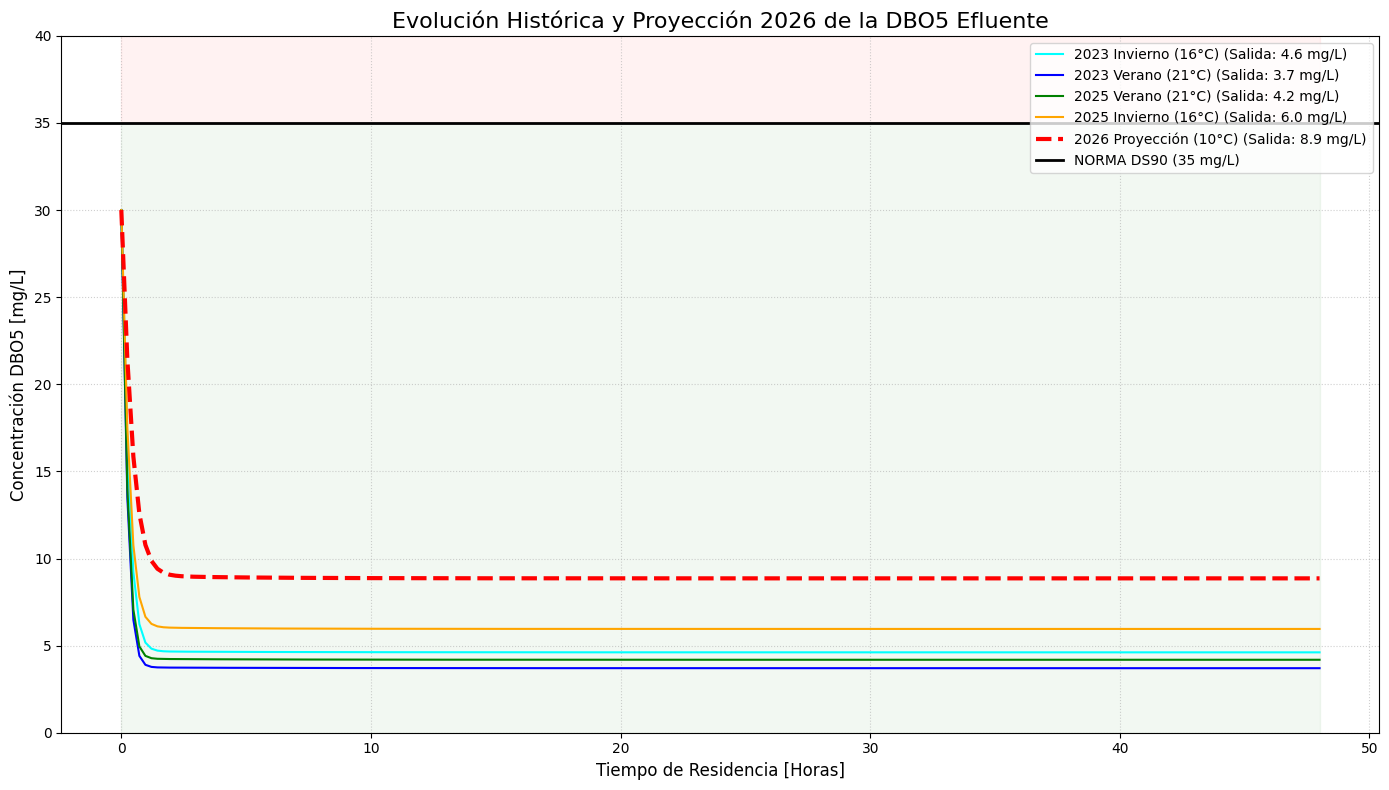


   ANÁLISIS DE DEADLINE (PUNTO DE QUIEBRE DS90)
La planta es muy robusta, no falló en el rango probado.

Resultados de Simulación:
 - 2023 Invierno (16°C): 4.61 mg/L -> CUMPLE
 - 2023 Verano (21°C): 3.70 mg/L -> CUMPLE
 - 2025 Verano (21°C): 4.19 mg/L -> CUMPLE
 - 2025 Invierno (16°C): 5.96 mg/L -> CUMPLE
 - 2026 Proyección (10°C): 8.86 mg/L -> CUMPLE


In [ ]:
#[DBO5]

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from math import exp

# ==========================================
# 1. PARÁMETROS GLOBALES (CONSTANTES)
# ==========================================
# Concentraciones
SE = 280.0   # [mg/L] DBO5 de Entrada (Afluente)
XE = 0.0     # [mg/L] Biomasa en Afluente
XR = 7000  # [mg/L] Biomasa en Recirculación (Lodo de fondo)
R  = 1.0     # Tasa de Recirculación (100%)

# Cinética (Monod + Arrhenius + Inhibición)
UMAX  = 0.05   # [1/h]
KD    = 0.0025 # [1/h]
KS    = 30.0   # [mg/L]
Y_XS  = 0.8    # [g/g]
THETA = 1.04   # Arrhenius
T_OPT = 35.0   # [°C] Temp. Óptima
K_T   = 0.05   # Sensibilidad térmica

# ==========================================
# 2. MOTOR DE SIMULACIÓN (FUNCIONES)
# ==========================================
def f_inhibicion(T_actual):
    if T_actual <= T_OPT:
        return 1.0
    else:
        return exp(-K_T * (T_actual - T_OPT))

def modelo_dinamico(y, t, params):
    # Desempaquetar condiciones y parámetros
    V_reactor, T_sim, Q_in = params
    V, X, S = y

    # Calcular Caudales con Recirculación
    Qr = Q_in * R

    # Cinética
    f_inhib = f_inhibicion(T_sim)
    mu_monod = (UMAX * S / (KS + S))
    mu_final = (mu_monod * (THETA**(T_sim - 20))) * f_inhib

    # Ecuaciones Diferenciales
    dVdt = 0 # Asumimos volumen constante

    # Balance Biomasa
    dXdt = (Q_in * XE + Qr * XR - (Q_in + Qr) * X + mu_final * X * V - KD * X * V) / V

    # Balance Sustrato
    #dSdt = (Q_in * SE + Qr * S - (Q_in + Qr) * S - (mu_final * X * V) / Y_XS) / V
    dSdt = (Q_in * (SE - S) - (mu_final * X * V) / Y_XS) / V

    return [dVdt, dXdt, dSdt]

# ==========================================
# 3. DEFINICIÓN DE ESCENARIOS (DATOS)
# ==========================================
# Aquí organizamos tus datos de 2023, 2025 y la proyección 2026
# Estructura: "Nombre": [Caudal (L/h), Volumen (L), Temperatura (°C), Color]

casos = {
    # DATOS 2023 (Invierno/Verano a Caudal 216m3)
    "2023 Invierno (16°C)":   [216000, 2345410, 16, "cyan"],
    "2023 Verano (21°C)":     [216000, 2345410, 21, "blue"],

    # DATOS 2025 (Verano 241.5m3 - Invierno 270.5m3)
    "2025 Verano (21°C)":     [241500, 2345410, 21, "green"], # Volumen ajustado según tu script 2025
    "2025 Invierno (16°C)":   [270500, 2345410, 16, "orange"],

    # PROYECCIÓN 2026 (+10% sobre el peor caso de 2025)
    # 270500 * 1.10 = 297,550 L/h
    "2026 Proyección (10°C)": [270500 * 1.1, 2345410, 10, "red"]
}
# ==========================================
# 4. EJECUCIÓN Y GRÁFICOS COMPARATIVOS
# ==========================================
t = np.linspace(0, 48, 200) # Simulación de 48 horas
plt.figure(figsize=(14, 8))

resultados_finales = []

for nombre, datos in casos.items():
    Q_sim, V_sim, T_sim, color = datos

    # Condiciones Iniciales (Asumimos planta estabilizada: 3500 mg/L)
    y0 = [V_sim, 3500, 30]

    # Resolver EDO
    # Pasamos los parámetros como una tupla (V, T, Q)
    sol = odeint(modelo_dinamico, y0, t, args=((V_sim, T_sim, Q_sim),))

    S_out = sol[:, 2] # DBO5 de salida
    dbo_final = S_out[-1]
    resultados_finales.append((nombre, dbo_final))

    # Graficar
    linewidth = 3 if "2026" in nombre else 1.5 # Resaltar la proyección
    linestyle = '--' if "2026" in nombre else '-'

    plt.plot(t, S_out, label=f'{nombre} (Salida: {dbo_final:.1f} mg/L)',
             color=color, linewidth=linewidth, linestyle=linestyle)

# Línea de la Norma DS90
plt.axhline(y=35, color='black', linestyle='-', linewidth=2, label='NORMA DS90 (35 mg/L)')

plt.title('Evolución Histórica y Proyección 2026 de la DBO5 Efluente', fontsize=16)
plt.xlabel('Tiempo de Residencia [Horas]', fontsize=12)
plt.ylabel('Concentración DBO5 [mg/L]', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10, loc='upper right')
plt.ylim([0,40])

# Colorear zonas
plt.fill_between(t, 0, 35, color='green', alpha=0.05) # Zona Cumplimiento
plt.fill_between(t, 35, SE, color='red', alpha=0.05)  # Zona Incumplimiento

plt.tight_layout()
plt.show()

# ==========================================
# 5. CÁLCULO DEL "DEADLINE" (ALERTA DE FALLA)
# ==========================================
print("\n" + "="*50)
print("   ANÁLISIS DE DEADLINE (PUNTO DE QUIEBRE DS90)")
print("="*50)

# Buscamos cuánto caudal aguanta la planta en Invierno (10°C) antes de fallar
# Usamos el volumen de 2025/2026 (1,606,310 L)
V_actual = 2345410
T_critica = 10 # Peor escenario térmico
Q_base = 270500 # Base invierno 2025

# Iteramos aumentando el caudal hasta que falle
for aumento in np.linspace(0, 100, 1000): # De 0% a 100% de aumento
    Q_test = Q_base * (1 + aumento/100)

    # Simular estado estacionario (t=48h)
    y0 = [V_actual, 3500, 30]
    sol = odeint(modelo_dinamico, y0, [0, 48], args=((V_actual, T_critica, Q_test),))
    dbo_final = sol[-1, 2]

    if dbo_final > 35.0:
        print(f"\n🚨 ALERTA DE COLAPSO NORMATIVO DETECTADA")
        print(f"Condición: Invierno ({T_critica}°C)")
        print(f"La planta dejará de cumplir la norma (35 mg/L) cuando:")
        print(f" -> El caudal alcance: {Q_test:.0f} L/h")
        print(f" -> Esto representa un aumento del {aumento:.1f}% respecto al Invierno 2025.")
        break
else:
    print("La planta es muy robusta, no falló en el rango probado.")

print("\nResultados de Simulación:")
for nombre, valor in resultados_finales:
    estado = "CUMPLE" if valor < 35 else "NO CUMPLE"
    print(f" - {nombre}: {valor:.2f} mg/L -> {estado}")

--- LÍMITE HIDRÁULICO CALCULADO ---
Área Total Decantación: 254.5 m2
Caudal Crítico de Lavado: 305.4 m3/h
----------------------------------------


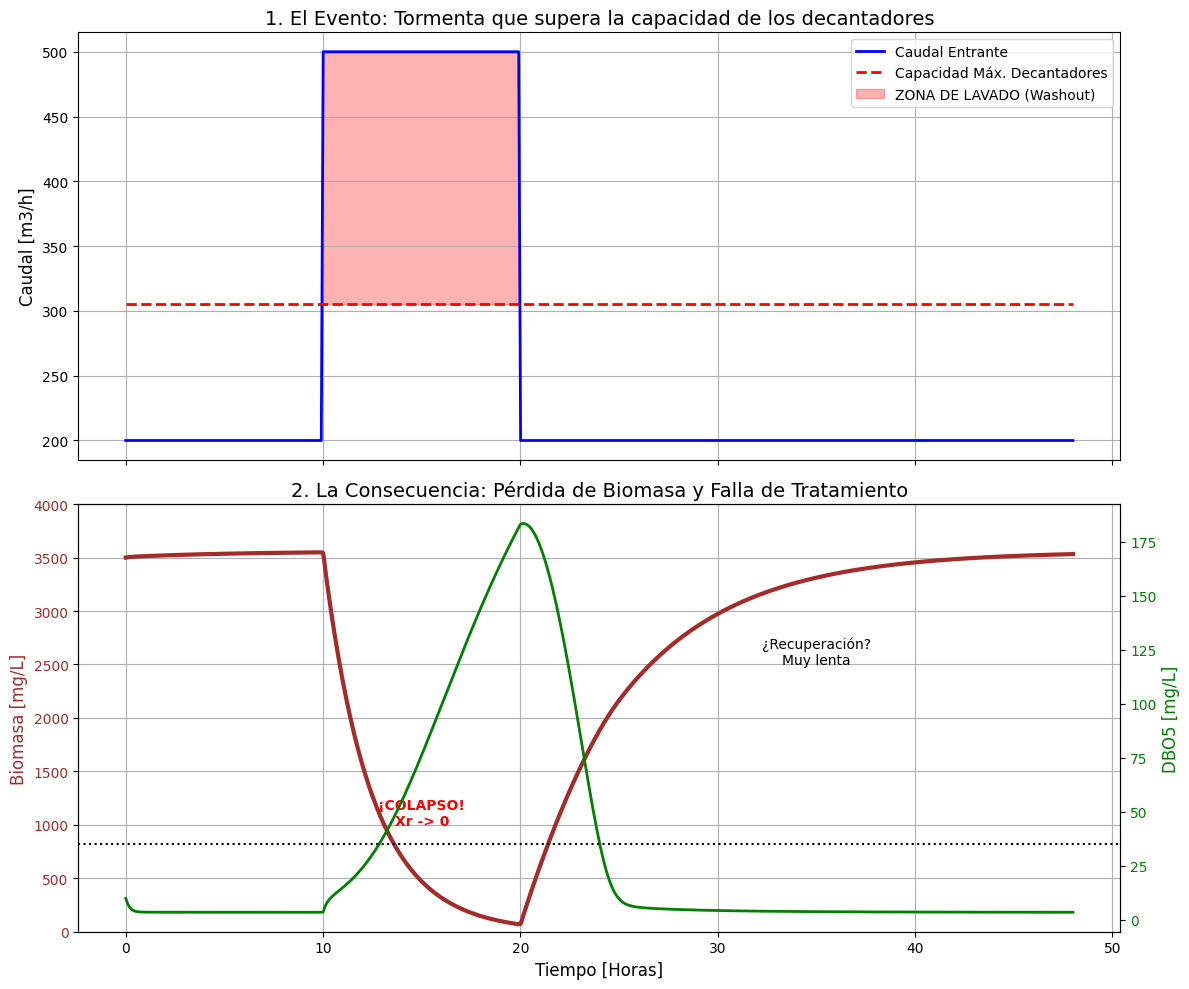

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from math import exp, pi

# ==========================================
# 1. PARÁMETROS FÍSICOS (DECANTADORES)
# ==========================================
# Según Memoria: 4 Decantadores de 9m de diámetro
NUM_DECANTADORES = 4
DIAMETRO = 9.0 # m
AREA_TOTAL = NUM_DECANTADORES * pi * (DIAMETRO/2)**2 # m2 (Aprox 254 m2)

# Límite Físico: Velocidad de sedimentación del lodo
V_SEDIMENTACION = 1.2 # [m/h] (Valor típico crítico)
# Caudal Máximo que soportan los decantadores antes de botar lodo
Q_CRITICO_LPH = (AREA_TOTAL * V_SEDIMENTACION) * 1000 # [L/h] (Aprox 305,000 L/h)

print(f"--- LÍMITE HIDRÁULICO CALCULADO ---")
print(f"Área Total Decantación: {AREA_TOTAL:.1f} m2")
print(f"Caudal Crítico de Lavado: {Q_CRITICO_LPH/1000:.1f} m3/h")
print("-" * 40)

# ==========================================
# 2. PARÁMETROS DEL REACTOR
# ==========================================
V_REACTOR = 2345410 # [L]
SE = 280.0   # [mg/L] DBO5 Entrada
XE = 0.0     # [mg/L]
XR_IDEAL = 7000.0 # [mg/L] Recirculación cuando funciona bien

# Cinética (Estándar)
UMAX, KD, KS, Y_XS = 0.05, 0.0025, 30.0, 0.8

# ==========================================
# 3. DEFINICIÓN DEL EVENTO (TORMENTA)
# ==========================================
def obtener_caudal_tormenta(t):
    """
    Simula un perfil de tormenta:
    - 0 a 10h: Flujo Normal (200 m3/h)
    - 10 a 20h: PICO DE TORMENTA (500 m3/h) -> Supera el crítico
    - 20 a 48h: Vuelta a la normalidad (200 m3/h)
    """
    if 10 <= t <= 20:
        return 500000.0 # [L/h] 500 m3/h (¡Colapso!)
    else:
        return 200000.0 # [L/h] 200 m3/h (Normal)

# ==========================================
# 4. MODELO DINÁMICO CON FALLA
# ==========================================
def modelo_colapso(y, t):
    V, X, S = y

    # A. Obtener Caudal del momento
    Q_in = obtener_caudal_tormenta(t)

    # B. Lógica de Falla del Decantador
    # Si el caudal entra más rápido de lo que el lodo cae, el lodo se escapa.
    if Q_in > Q_CRITICO_LPH:
        # ¡FALLA HIDRÁULICA!
        # El lodo se va por el efluente. No hay nada en el fondo para recircular.
        Xr_actual = 0.0
    else:
        # Operación Normal
        Xr_actual = XR_IDEAL

    Qr = Q_in * 1.0 # Recirculación 100%

    # C. Ecuaciones Diferenciales
    # Nota: Usamos una cinetica simple sin T° para aislar el efecto hidráulico
    mu = UMAX * S / (KS + S)

    dXdt = (Q_in * XE + Qr * Xr_actual - (Q_in + Qr) * X + mu * X * V - KD * X * V) / V
    dSdt = (Q_in * SE + Qr * S - (Q_in + Qr) * S - (mu * X * V) / Y_XS) / V

    return [0, dXdt, dSdt] # dVdt = 0

# ==========================================
# 5. SIMULACIÓN Y GRÁFICO
# ==========================================
t = np.linspace(0, 48, 500)
y0 = [V_REACTOR, 3500, 10] # Estado inicial sano

sol = odeint(modelo_colapso, y0, t)
X_out = sol[:, 1] # Biomasa
S_out = sol[:, 2] # DBO5

# --- GRÁFICOS ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Gráfico 1: El Evento Hidráulico
caudales = [obtener_caudal_tormenta(ti)/1000 for ti in t]
limite = [Q_CRITICO_LPH/1000 for ti in t]

ax1.plot(t, caudales, 'b-', label='Caudal Entrante', linewidth=2)
ax1.plot(t, limite, 'r--', label='Capacidad Máx. Decantadores', linewidth=2)
ax1.fill_between(t, caudales, limite, where=([c > l for c, l in zip(caudales, limite)]),
                 color='red', alpha=0.3, label='ZONA DE LAVADO (Washout)')
ax1.set_ylabel('Caudal [m3/h]', fontsize=12)
ax1.set_title('1. El Evento: Tormenta que supera la capacidad de los decantadores', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True)

# Gráfico 2: Consecuencia Biológica
ax2.plot(t, X_out, 'brown', label='Biomasa en Reactor (X)', linewidth=3)
ax2.set_ylabel('Biomasa [mg/L]', color='brown', fontsize=12)
ax2.tick_params(axis='y', labelcolor='brown')
ax2.set_ylim(0, 4000)

# Eje gemelo para DBO
ax3 = ax2.twinx()
ax3.plot(t, S_out, 'green', label='DBO5 Efluente', linewidth=2)
ax3.set_ylabel('DBO5 [mg/L]', color='green', fontsize=12)
ax3.tick_params(axis='y', labelcolor='green')
ax3.axhline(y=35, color='black', linestyle=':', label='Norma DS90')

ax2.set_title('2. La Consecuencia: Pérdida de Biomasa y Falla de Tratamiento', fontsize=14)
ax2.set_xlabel('Tiempo [Horas]', fontsize=12)
ax2.grid(True)

# Añadir textos explicativos
ax2.text(15, 1000, "¡COLAPSO!\nXr -> 0", color='red', fontweight='bold', ha='center')
ax2.text(35, 2500, "¿Recuperación?\nMuy lenta", color='black', ha='center')

plt.tight_layout()
plt.show()